# Loading Data 

## Importing libraries and txt file

We can seperate the txt file into different features, since we don't know the physical qualities each index represent we will keep them as strings that correspond to each number.

In [1]:
import os
import tensorflow as tf
import datetime
import sys
from os import path
import numpy as np
import pandas as pd

# Import data to panda frames
headings_data =map(str, range(45 + 1))
data_input = pd.read_csv('input.txt', delim_whitespace=True, header=None, names =  [str(x) for x in range(49)])
data_output = pd.read_csv('output.txt', delim_whitespace=True, header=None, names = ['class'])

# Seperate the different classes (usefull in heavily unbalanced class problems like this one)
data_input_flares= data_input.loc[0:n_flares-1,:]
data_input_seps = data_input.loc[0+n_flares:n_SEPS+n_flares,:]
data_outputflares = data_output.loc[0:n_flares-1,:]
data_output_seps = data_output.loc[n_flares:n_SEPS+n_flares,:]


## Creating Train & Test sets

Now we can generate all the different train and test sets for the project

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

x_train, x_test, y_train_init, y_test_init = train_test_split(data_input, data_output,  stratify=data_output, test_size=0.1, random_state=2)

# Add a min_max scaler which is fited in training data
standar_scaler_model= preprocessing.StandardScaler()
standar_scaler_model.fit(x_train)  

x_scaled_train = standar_scaler_model.transform(x_train) # Transform to normalized data 
x_scaled_test = standar_scaler_model.transform(x_test) # Transform to normalized data 

# Change back to dataframes
x_train_rescaled = pd.DataFrame(x_scaled_train, index=x_train.index, columns=x_train.columns)
x_test_rescaled = pd.DataFrame(x_scaled_test, index=x_test.index, columns=x_test.columns)


## Verification of Pre-process normzliation

We can check the results compared to the custom made function that we import ourselves

In [3]:
from utility_functions_SR import normalizeRevisted

x_train_normalized = normalizeRevisted(x_train,x_train)
x_test_normalized = normalizeRevisted(x_test,x_train)

Indeed, the normalization functions work equally well.

## Split smaller dataset for flares

Since we have way too many flares we should split the training set to have fewer.

In [4]:
number_train_flares = 1500

x_train_rescaled_SEPS = x_train_rescaled.loc[y_train_init['class'] == 1] 
x_train_rescaled_flares  = x_train_rescaled.loc[y_train_init['class'] == 0] 

#Alternative way to calculate remaining flares
#x_train_rescaled_flares2 =  pd.concat([x_train_rescaled_SEPS,x_train_rescaled]).drop_duplicates(keep=False)


#undersampled_flares
x_train_rescaled_undersampled_flares = x_train_rescaled_flares.sample(number_train_flares,random_state=2)

#remaining flares to be added to test set
remaining_flares_x = x_train_rescaled_flares.drop(x_train_rescaled_undersampled_flares.index.values)
remaining_flares__and_seps_y = y_train_init.drop(x_train_rescaled_undersampled_flares.index.values)
remaining_flares_y = remaining_flares__and_seps_y.drop(x_train_rescaled_SEPS.index.values)

x_test_rescaled = pd.concat([x_test_rescaled,remaining_flares_x])
y_test_init = pd.concat([y_test_init,remaining_flares_y])

#y_train_rescaled_undersampled_flares = y_train_init.loc[x_train_rescaled_undersampled_flares.index.values]

# Create the new training set
x_train_rescaled = pd.concat([x_train_rescaled_undersampled_flares,x_train_rescaled_SEPS])
y_train_init = y_train_init.loc[x_train_rescaled.index.values]


In [5]:
print(x_train_rescaled_flares.shape[0])
print(remaining_flares_x.shape[0]+x_train_rescaled_undersampled_flares.shape[0])
print(x_test_rescaled.shape[0] + x_train_rescaled.shape[0])
print(y_test_init.shape[0] + y_train_init.shape[0])
17875+226

16087
16087
18101
18101


18101

## Over-sampling / Under-sampling options

We can also try another approach, to unersample or oversample our data

## NOTE: this doesn't provide better results in the trials so far


In [152]:
from imblearn.over_sampling import SMOTE,ADASYN,SVMSMOTE,KMeansSMOTE,BorderlineSMOTE,RandomOverSampler
from tensorflow.keras.utils import to_categorical

# change to categorical variable for the output

y_train = to_categorical(y_train_init)
y_test = to_categorical(y_test_init)


x_resampled, y_resampled = BorderlineSMOTE().fit_resample(x_train_rescaled, y_train)


x_train_rescaled = x_resampled
y_train = to_categorical(y_resampled)

C:\Users\savvra\.conda\envs\ML_Tensor_2\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


## Example of Model Setup

Let's setup a model below

In [6]:
import NN_models_SR 
import importlib
importlib.reload(NN_models_SR)
from NN_models_SR import simple_model
from NN_models_SR import deeper_model
from tensorflow.keras.utils import to_categorical
# change to categorical variable for the output

y_train = to_categorical(y_train_init)
y_test = to_categorical(y_test_init)

x_train_normalized_features = x_train_rescaled[columns_sigiava_uses]
x_test_normalized_features = x_test_rescaled[columns_sigiava_uses]

nin = len(x_train_normalized_features.columns)


SGD_2 = tf.keras.optimizers.SGD(
    learning_rate=0.005, momentum=0.5, nesterov=True
)

optimizer_choice_1 = 'Adam'
optimizer_choise_2 = SGD_2
scaling_factor_loss = 100

scaling_factor = len(y_train[y_train[:,1] ==0])/len(y_train[y_train[:,1] ==1])


model_used = deeper_model(nin,number_of_classes,optimizer_choise_2,scaling_factor_loss)

class_weight_choice = {0: 1,
                1: scaling_factor}

In [7]:
class_weight_choice


{0: 1, 1: 7.389162561576355}

## Example of Training proccedure


Let's now train our model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size_choice = round(len(x_train_normalized_features))

early_stop = EarlyStopping(monitor='loss' , min_delta=1e-04, patience=50 , verbose=1,
                                   mode ='auto', restore_best_weights= True)

#history = model_used.fit(x_train_normalized_features, y_train, epochs=30, batch_size=batch_size_choice, 
#                         verbose=0)

history = model_used.fit(x_train_normalized_features, y_train, epochs=1000, batch_size=batch_size_choice, 
                         verbose=2, 
                         callbacks=[early_stop],
                             validation_data = (x_test_normalized_features, y_test))
#class_weight=class_weight_choice,
# callbacks=[early_stop],


Train on 1703 samples, validate on 16398 samples
Epoch 1/1000
1703/1703 - 7s - loss: 3.8464 - acc: 0.5514 - f1_m: 0.5514 - precision_m: 0.5514 - recall_m: 0.5514 - val_loss: 0.9254 - val_acc: 0.2223 - val_f1_m: 0.2219 - val_precision_m: 0.2219 - val_recall_m: 0.2219
Epoch 2/1000
1703/1703 - 0s - loss: 1.7594 - acc: 0.6078 - f1_m: 0.6078 - precision_m: 0.6078 - recall_m: 0.6078 - val_loss: 0.9618 - val_acc: 0.2208 - val_f1_m: 0.2203 - val_precision_m: 0.2203 - val_recall_m: 0.2203
Epoch 3/1000
1703/1703 - 0s - loss: 1.6073 - acc: 0.6201 - f1_m: 0.6201 - precision_m: 0.6201 - recall_m: 0.6201 - val_loss: 0.9852 - val_acc: 0.2148 - val_f1_m: 0.2144 - val_precision_m: 0.2144 - val_recall_m: 0.2144
Epoch 4/1000
1703/1703 - 0s - loss: 1.5428 - acc: 0.6218 - f1_m: 0.6218 - precision_m: 0.6218 - recall_m: 0.6218 - val_loss: 1.0002 - val_acc: 0.2061 - val_f1_m: 0.2058 - val_precision_m: 0.2058 - val_recall_m: 0.2058
Epoch 5/1000
1703/1703 - 0s - loss: 1.5039 - acc: 0.6218 - f1_m: 0.6218 - preci

Epoch 39/1000
1703/1703 - 0s - loss: 1.1332 - acc: 0.7076 - f1_m: 0.7076 - precision_m: 0.7076 - recall_m: 0.7076 - val_loss: 0.9492 - val_acc: 0.4094 - val_f1_m: 0.4097 - val_precision_m: 0.4097 - val_recall_m: 0.4097
Epoch 40/1000
1703/1703 - 0s - loss: 1.1262 - acc: 0.7093 - f1_m: 0.7093 - precision_m: 0.7093 - recall_m: 0.7093 - val_loss: 0.9457 - val_acc: 0.4166 - val_f1_m: 0.4171 - val_precision_m: 0.4171 - val_recall_m: 0.4171
Epoch 41/1000
1703/1703 - 0s - loss: 1.1192 - acc: 0.7099 - f1_m: 0.7099 - precision_m: 0.7099 - recall_m: 0.7099 - val_loss: 0.9418 - val_acc: 0.4236 - val_f1_m: 0.4240 - val_precision_m: 0.4240 - val_recall_m: 0.4240
Epoch 42/1000
1703/1703 - 0s - loss: 1.1123 - acc: 0.7105 - f1_m: 0.7105 - precision_m: 0.7105 - recall_m: 0.7105 - val_loss: 0.9381 - val_acc: 0.4301 - val_f1_m: 0.4304 - val_precision_m: 0.4304 - val_recall_m: 0.4304
Epoch 43/1000
1703/1703 - 0s - loss: 1.1055 - acc: 0.7129 - f1_m: 0.7129 - precision_m: 0.7129 - recall_m: 0.7129 - val_loss

Epoch 77/1000
1703/1703 - 0s - loss: 0.9041 - acc: 0.7757 - f1_m: 0.7757 - precision_m: 0.7757 - recall_m: 0.7757 - val_loss: 0.7901 - val_acc: 0.6401 - val_f1_m: 0.6394 - val_precision_m: 0.6394 - val_recall_m: 0.6394
Epoch 78/1000
1703/1703 - 0s - loss: 0.8987 - acc: 0.7769 - f1_m: 0.7769 - precision_m: 0.7769 - recall_m: 0.7769 - val_loss: 0.7855 - val_acc: 0.6450 - val_f1_m: 0.6444 - val_precision_m: 0.6444 - val_recall_m: 0.6444
Epoch 79/1000
1703/1703 - 0s - loss: 0.8934 - acc: 0.7804 - f1_m: 0.7804 - precision_m: 0.7804 - recall_m: 0.7804 - val_loss: 0.7808 - val_acc: 0.6485 - val_f1_m: 0.6477 - val_precision_m: 0.6477 - val_recall_m: 0.6477
Epoch 80/1000
1703/1703 - 0s - loss: 0.8881 - acc: 0.7845 - f1_m: 0.7845 - precision_m: 0.7845 - recall_m: 0.7845 - val_loss: 0.7767 - val_acc: 0.6525 - val_f1_m: 0.6518 - val_precision_m: 0.6518 - val_recall_m: 0.6518
Epoch 81/1000
1703/1703 - 0s - loss: 0.8829 - acc: 0.7845 - f1_m: 0.7845 - precision_m: 0.7845 - recall_m: 0.7845 - val_loss

Epoch 115/1000
1703/1703 - 0s - loss: 0.7142 - acc: 0.8244 - f1_m: 0.8244 - precision_m: 0.8244 - recall_m: 0.8244 - val_loss: 0.6194 - val_acc: 0.7564 - val_f1_m: 0.7559 - val_precision_m: 0.7559 - val_recall_m: 0.7559
Epoch 116/1000
1703/1703 - 0s - loss: 0.7097 - acc: 0.8262 - f1_m: 0.8262 - precision_m: 0.8262 - recall_m: 0.8262 - val_loss: 0.6154 - val_acc: 0.7584 - val_f1_m: 0.7580 - val_precision_m: 0.7580 - val_recall_m: 0.7580
Epoch 117/1000
1703/1703 - 0s - loss: 0.7052 - acc: 0.8256 - f1_m: 0.8256 - precision_m: 0.8256 - recall_m: 0.8256 - val_loss: 0.6114 - val_acc: 0.7611 - val_f1_m: 0.7607 - val_precision_m: 0.7607 - val_recall_m: 0.7607
Epoch 118/1000
1703/1703 - 0s - loss: 0.7008 - acc: 0.8280 - f1_m: 0.8280 - precision_m: 0.8280 - recall_m: 0.8280 - val_loss: 0.6072 - val_acc: 0.7629 - val_f1_m: 0.7624 - val_precision_m: 0.7624 - val_recall_m: 0.7624
Epoch 119/1000
1703/1703 - 0s - loss: 0.6965 - acc: 0.8291 - f1_m: 0.8291 - precision_m: 0.8291 - recall_m: 0.8291 - val

Epoch 153/1000
1703/1703 - 0s - loss: 0.5660 - acc: 0.8673 - f1_m: 0.8673 - precision_m: 0.8673 - recall_m: 0.8673 - val_loss: 0.4794 - val_acc: 0.8270 - val_f1_m: 0.8263 - val_precision_m: 0.8263 - val_recall_m: 0.8263
Epoch 154/1000
1703/1703 - 0s - loss: 0.5627 - acc: 0.8673 - f1_m: 0.8673 - precision_m: 0.8673 - recall_m: 0.8673 - val_loss: 0.4763 - val_acc: 0.8283 - val_f1_m: 0.8276 - val_precision_m: 0.8276 - val_recall_m: 0.8276
Epoch 155/1000
1703/1703 - 0s - loss: 0.5592 - acc: 0.8679 - f1_m: 0.8679 - precision_m: 0.8679 - recall_m: 0.8679 - val_loss: 0.4729 - val_acc: 0.8296 - val_f1_m: 0.8290 - val_precision_m: 0.8290 - val_recall_m: 0.8290
Epoch 156/1000
1703/1703 - 0s - loss: 0.5558 - acc: 0.8696 - f1_m: 0.8696 - precision_m: 0.8696 - recall_m: 0.8696 - val_loss: 0.4705 - val_acc: 0.8308 - val_f1_m: 0.8302 - val_precision_m: 0.8302 - val_recall_m: 0.8302
Epoch 157/1000
1703/1703 - 0s - loss: 0.5524 - acc: 0.8696 - f1_m: 0.8696 - precision_m: 0.8696 - recall_m: 0.8696 - val

Epoch 191/1000
1703/1703 - 0s - loss: 0.4511 - acc: 0.8914 - f1_m: 0.8914 - precision_m: 0.8914 - recall_m: 0.8914 - val_loss: 0.3761 - val_acc: 0.8698 - val_f1_m: 0.8690 - val_precision_m: 0.8690 - val_recall_m: 0.8690
Epoch 192/1000
1703/1703 - 0s - loss: 0.4484 - acc: 0.8920 - f1_m: 0.8920 - precision_m: 0.8920 - recall_m: 0.8920 - val_loss: 0.3737 - val_acc: 0.8704 - val_f1_m: 0.8695 - val_precision_m: 0.8695 - val_recall_m: 0.8695
Epoch 193/1000
1703/1703 - 0s - loss: 0.4457 - acc: 0.8914 - f1_m: 0.8914 - precision_m: 0.8914 - recall_m: 0.8914 - val_loss: 0.3713 - val_acc: 0.8718 - val_f1_m: 0.8709 - val_precision_m: 0.8709 - val_recall_m: 0.8709
Epoch 194/1000
1703/1703 - 0s - loss: 0.4432 - acc: 0.8931 - f1_m: 0.8931 - precision_m: 0.8931 - recall_m: 0.8931 - val_loss: 0.3700 - val_acc: 0.8725 - val_f1_m: 0.8718 - val_precision_m: 0.8718 - val_recall_m: 0.8718
Epoch 195/1000
1703/1703 - 0s - loss: 0.4406 - acc: 0.8937 - f1_m: 0.8937 - precision_m: 0.8937 - recall_m: 0.8937 - val

# Visualziating results (simple metrics)

Let's see the results

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


predictions = model_used.predict_classes(x_test_normalized_features)
y_test_binary = np.argmax(y_test, axis=1)
    
cr = classification_report(y_test_binary, predictions)
cm = confusion_matrix(y_test_binary, predictions)


In [8]:
print(cm)
print("Class 1 accuracy")
print(cm[0,0]/(cm[0,0]+cm[0,1]))

print("Class 2 accuracy")
print(cm[1,1]/(cm[1,0]+cm[1,1]))

print(model_used.summary())

from tensorflow.keras.utils import plot_model
plot_model(model_used, to_file='model.png', show_shapes=True, show_layer_names=True)


[[15471   904]
 [    3    20]]
Class 1 accuracy
0.944793893129771
Class 2 accuracy
0.8695652173913043
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                4080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80)                320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 80)                0         
____________________

AssertionError: 1

## Visualziating results (Plots)

Let's see the results

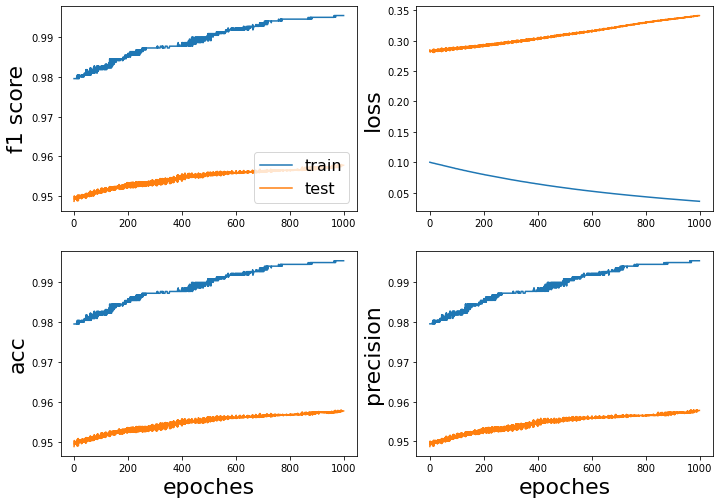

In [41]:
import matplotlib.pyplot as plt

val_f1 = history.history['val_f1_m']
val_loss= history.history['val_loss']
val_acc= history.history['val_acc']
val_prec= history.history['val_precision_m']

train_f1 = history.history['f1_m']
train_loss = history.history['loss']
train_acc = history.history['acc']
train_prec = history.history['precision_m']


plt.figure(figsize=(11.69,8.27))
plt.subplot(2, 2, 1)
plt.plot(train_f1)
plt.plot(val_f1)
plt.ylabel('f1 score',fontsize=22)
plt.legend(['train', 'test'], loc='lower right',fontsize=16)

plt.subplot(2, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.ylabel('loss',fontsize=22)

plt.subplot(2, 2, 3)
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epoches',fontsize=22)
plt.ylabel('acc',fontsize=22)

plt.subplot(2, 2, 4)
plt.plot(train_prec)
plt.plot(val_prec)
plt.xlabel('epoches',fontsize=22)
plt.ylabel('precision',fontsize=22)

plt.show()



## Saving the model results

We can also save the models and the results on a seperate folder for later inspection and comparison.

[array([[ 0.32085901, -0.32489896,  0.12394738, -0.19034779, -0.04600435,
         -0.45268458,  0.23795146, -0.34619462, -0.1940652 , -0.15396744,
          0.04119447,  0.47324803, -0.17350823,  0.08260909,  0.31482396,
         -0.44640478,  0.06404068, -0.26807967, -0.3192674 ,  0.29012108,
         -0.07029019,  0.19925912,  0.13658576, -0.12929   , -0.20414212,
         -0.02257867, -0.1499145 ,  0.0652842 , -0.24789953,  0.42986786],
        [-0.03313516,  0.30596155, -0.24444357, -0.18280828, -0.23591113,
          0.13154536,  0.30090284,  0.351675  ,  0.43960422, -0.08786726,
          0.27882358, -0.35452634, -0.22503737, -0.24115402, -0.12261014,
         -0.4349011 ,  0.36342362, -0.2760502 ,  0.27691847, -0.25640815,
         -0.30272776, -0.02089384,  0.3326967 ,  0.2551555 ,  0.2656688 ,
         -0.31374   , -0.48161927,  0.41109926,  0.15560456, -0.35362053],
        [-0.27015388,  0.19154528,  0.1851229 , -0.09069154,  0.07799237,
         -0.26885274, -0.40004495,  